In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [2]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [3]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [4]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [5]:
def train_test_split(length, split=0.7):
    indices = np.random.permutation(length)
    split_len = int(length*split)
    return indices[:split_len], indices[split_len:]

In [6]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [7]:
X, Y = [], []
for box in params:
    X += [list(cosmo_params[box].values())]
    Y += [list(params[box].values())]
X = np.array(X)
Y = np.array(Y)

training_idx, testing_idx = train_test_split(len(X), split=0.9)
X_train, X_test = X[training_idx], X[testing_idx]
Y_train, Y_test = Y[training_idx], Y[testing_idx]

box_train = np.array(list(params.keys()))[training_idx]
box_test = np.array(list(params.keys()))[testing_idx]


X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Y_train, Y_test = torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()

n_tasks = len(Y_train[0])

In [29]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=n_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]), num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Y_train, likelihood)

In [30]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [31]:
training_iterations = 800
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/800 - Loss: 1.344
Iter 2/800 - Loss: 1.284
Iter 3/800 - Loss: 1.227
Iter 4/800 - Loss: 1.171
Iter 5/800 - Loss: 1.119
Iter 6/800 - Loss: 1.068
Iter 7/800 - Loss: 1.020
Iter 8/800 - Loss: 0.972
Iter 9/800 - Loss: 0.925
Iter 10/800 - Loss: 0.876
Iter 11/800 - Loss: 0.828
Iter 12/800 - Loss: 0.779
Iter 13/800 - Loss: 0.732
Iter 14/800 - Loss: 0.685
Iter 15/800 - Loss: 0.638
Iter 16/800 - Loss: 0.593
Iter 17/800 - Loss: 0.548
Iter 18/800 - Loss: 0.503
Iter 19/800 - Loss: 0.459
Iter 20/800 - Loss: 0.414
Iter 21/800 - Loss: 0.368
Iter 22/800 - Loss: 0.322
Iter 23/800 - Loss: 0.275
Iter 24/800 - Loss: 0.229
Iter 25/800 - Loss: 0.185
Iter 26/800 - Loss: 0.141
Iter 27/800 - Loss: 0.099
Iter 28/800 - Loss: 0.057
Iter 29/800 - Loss: 0.016
Iter 30/800 - Loss: -0.023
Iter 31/800 - Loss: -0.061
Iter 32/800 - Loss: -0.098
Iter 33/800 - Loss: -0.136
Iter 34/800 - Loss: -0.172
Iter 35/800 - Loss: -0.207
Iter 36/800 - Loss: -0.242
Iter 37/800 - Loss: -0.277
Iter 38/800 - Loss: -0.311
Iter 39/800 

Iter 309/800 - Loss: -1.222
Iter 310/800 - Loss: -1.222
Iter 311/800 - Loss: -1.222
Iter 312/800 - Loss: -1.222
Iter 313/800 - Loss: -1.223
Iter 314/800 - Loss: -1.223
Iter 315/800 - Loss: -1.223
Iter 316/800 - Loss: -1.222
Iter 317/800 - Loss: -1.222
Iter 318/800 - Loss: -1.222
Iter 319/800 - Loss: -1.221
Iter 320/800 - Loss: -1.220
Iter 321/800 - Loss: -1.218
Iter 322/800 - Loss: -1.213
Iter 323/800 - Loss: -1.208
Iter 324/800 - Loss: -1.204
Iter 325/800 - Loss: -1.212
Iter 326/800 - Loss: -1.221
Iter 327/800 - Loss: -1.222
Iter 328/800 - Loss: -1.217
Iter 329/800 - Loss: -1.220
Iter 330/800 - Loss: -1.222
Iter 331/800 - Loss: -1.220
Iter 332/800 - Loss: -1.221
Iter 333/800 - Loss: -1.222
Iter 334/800 - Loss: -1.221
Iter 335/800 - Loss: -1.221
Iter 336/800 - Loss: -1.222
Iter 337/800 - Loss: -1.222
Iter 338/800 - Loss: -1.221
Iter 339/800 - Loss: -1.223
Iter 340/800 - Loss: -1.223
Iter 341/800 - Loss: -1.222
Iter 342/800 - Loss: -1.223
Iter 343/800 - Loss: -1.224
Iter 344/800 - Loss:

Iter 604/800 - Loss: -1.220
Iter 605/800 - Loss: -1.220
Iter 606/800 - Loss: -1.221
Iter 607/800 - Loss: -1.221
Iter 608/800 - Loss: -1.222
Iter 609/800 - Loss: -1.223
Iter 610/800 - Loss: -1.223
Iter 611/800 - Loss: -1.224
Iter 612/800 - Loss: -1.225
Iter 613/800 - Loss: -1.225
Iter 614/800 - Loss: -1.226
Iter 615/800 - Loss: -1.226
Iter 616/800 - Loss: -1.227
Iter 617/800 - Loss: -1.227
Iter 618/800 - Loss: -1.228
Iter 619/800 - Loss: -1.229
Iter 620/800 - Loss: -1.229
Iter 621/800 - Loss: -1.229
Iter 622/800 - Loss: -1.230
Iter 623/800 - Loss: -1.230
Iter 624/800 - Loss: -1.230
Iter 625/800 - Loss: -1.231
Iter 626/800 - Loss: -1.231
Iter 627/800 - Loss: -1.231
Iter 628/800 - Loss: -1.231
Iter 629/800 - Loss: -1.231
Iter 630/800 - Loss: -1.231
Iter 631/800 - Loss: -1.231
Iter 632/800 - Loss: -1.231
Iter 633/800 - Loss: -1.230
Iter 634/800 - Loss: -1.226
Iter 635/800 - Loss: -1.214
Iter 636/800 - Loss: -1.156
Iter 637/800 - Loss: -1.077
Iter 638/800 - Loss: -0.990
Iter 639/800 - Loss:

In [32]:
from utils import *
from massfunction import *

In [33]:
import random

box =random.choice(box_test)
# box = random.choice(box_train)
mass_function = MassFunction(cosmo_params[box])

In [34]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    samples = predictions.sample(torch.Size([1000])) 
    mean = predictions.mean

mean = dict(zip(box_test, mean))
samples = dict(zip(box_test, np.transpose(samples, axes=[1,0,2])))


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_train))
    samples_train = predictions.sample(torch.Size([1000])) 
    mean_train = predictions.mean
mean_train = dict(zip(box_train, mean_train))
samples_train = dict(zip(box_train, np.transpose(samples_train, axes=[1,0,2])))

mean = mean | mean_train
samples = samples | samples_train

/oak/stanford/orgs/kipac/users/delon/miniconda3/envs/massfunction/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [35]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
    if(a != 1): #TEST
        continue
        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

In [36]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [37]:
a_list = list(NvMs.keys())

100%|██████████| 1000/1000 [00:03<00:00, 289.80it/s]
/tmp/ipykernel_29890/1922378701.py:106: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


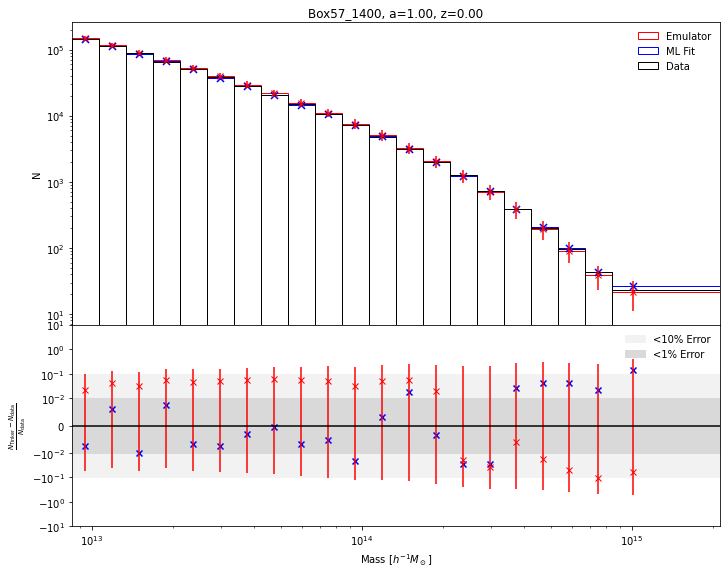

In [38]:
from multiprocessing import Pool

def estimate_uncertainty(param_combo):
    c_params = dict(zip(param_names, param_combo)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    return tinker_eval_MCMC

for a in reversed(N_data):
    if(a != 1):
        continue
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])

    

    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = list(tqdm(pool.imap(estimate_uncertainty, samples[box]), 
                                     total=len(samples[box])))    
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)



    #Emulator 
    c_params = dict(zip(param_names, mean[box])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].errorbar(Ms, tinker_eval_MCMC, emulator_uncertainty, fmt='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, emulator_uncertainty/N, fmt='x', color='red')

    #ML Fit
    params = None
    if(box in box_test):
        params = Y_test[np.where(box_test==box)][0]
    elif(box in box_train):
        params = Y_train[np.where(box_train==box)][0]

    c_params = dict(zip(param_names, params)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
    i+=1

    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_ylim((-1e1, 1e1))
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')